In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
class Actor(tf.keras.Model):
    def __init__(self):
        super(Actor, self).__init__()
        self.main = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), bias_initializer="ones", 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=5, padding="same"),
            layers.Flatten(),
            layers.Softmax(),
            layers.Reshape((BOARD_SIZE, BOARD_SIZE))
        ])
        
        self.pass_decision = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Flatten(),
            layers.Dense(4 * BOARD_SIZE**2),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(BOARD_SIZE**2),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(BOARD_SIZE),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(1, activation="sigmoid"),
        ])
    def call(self, inputs):
        action_prob_distr = self.main(inputs)
        pass_decision = self.pass_decision(inputs)
        return action_prob_distr, pass_decision

In [9]:
actor = Actor()

In [10]:
critic = tf.keras.Sequential([
    layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Reshape((BOARD_SIZE, BOARD_SIZE))
])

In [11]:
import os
if not os.path.exists('tmp'):
    os.mkdir('tmp/')
actor.save_weights('tmp/opp.h5')
opponent = Actor()
opponent.load_weights('tmp/opp.h5')

In [12]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [13]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[0], state[1], state[2], state[3]] if not channels_last else 
                                          [state[:,:,0], state[:,:,1], state[:,:,2], state[:,:,3]], 
                                          ['black', 'white', 'invalid', 'pass'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

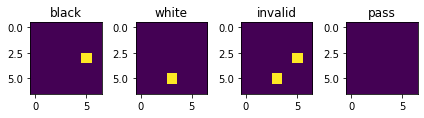

In [14]:
plot_state(state, channels_last=False)

In [15]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

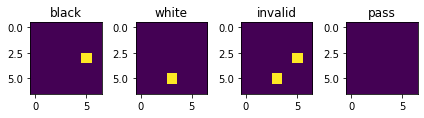

In [16]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [17]:
probs, pass_decision = actor(state.astype(np.float32))

In [18]:
values = critic.predict(state)

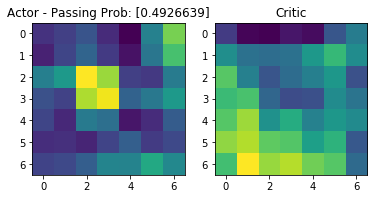

In [19]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {}'.format(pass_decision[0]))
plt.imshow(probs[0])
plt.subplot(1,2,2)
plt.title('Critic')
plt.imshow(values[0])

# Training Setup

### Hyperparameters

In [20]:
NUM_EPISODES = 10
BATCH_SIZE = 64
REPLAY_MEM_SIZE = 1e6
OPPONENT_UPDATE = 10
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.05

In [21]:
from collections import deque

In [22]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [23]:
actor_loss = tf.keras.metrics.Mean('actor_loss', dtype=tf.float32)
critic_loss = tf.keras.metrics.Mean('critic_loss', dtype=tf.float32)

Tensorboard

In [24]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

### Functions

In [25]:
def random_weighted_action(state, pass_prob, board_weights):
    illegal_mask = state[2]

    masked_prob = np.where(illegal_mask == 0, board_weights, 0)

    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.sum(masked_prob) <= 0:
        action = None
    else:
        # Uniform random chance for all places
        masked_prob /= np.sum(masked_prob)

        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=masked_prob.flatten())
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [26]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=np.ones((BOARD_SIZE, BOARD_SIZE)))
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        act_prob_distr, pass_decision = policy(state
                                               .reshape(1, BOARD_SIZE, BOARD_SIZE, 4)
                                               .astype(np.float32))
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [27]:
def play(episode):
    '''
    :return: number of turns in this game, winner ('b'/'w'/None)
    '''
    done = False
    num_of_turns = 0
    state = go_env.reset()
    
    while not done:
        
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
            
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        if done:
            break
        
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, 0)
        
        if action is None:
            logging.debug("White (opponent) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        
    # log results
    with train_summary_writer.as_default():
        tf.summary.scalar('number of moves', num_of_turns, step=episode)
        tf.summary.scalar('winner', reward > 0, step=episode)

In [28]:
def update_critic():
    pass

In [29]:
def update_actor():
    pass

In [30]:
def train(episode):
    global EPSILON
    
    if episode % OPPONENT_UPDATE == 0:
        # TODO sync opponent
        pass
    
    play(episode)
    update_critic()
    
    update_actor()
    
    # Update exploration/exploitation
    if EPSILON > EPSILON_MIN:
        EPSILON *= EPSILON_DECAY

# Train

In [31]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [32]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 59977), started 1 day, 8:37:17 ago. (Use '!kill 59977' to kill it.)

In [ ]:
for episode in range(NUM_EPISODES):
    train(episode)

# Evaluate
Play against the actor 💪